In [2]:
import numpy as np
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
import sys
sys.path.insert(0,"/Users/shuaizha/my_pymodule/")
from plot_defaults import *
homedir='/Users/shuaizha/'
sys.path.insert(1,homedir+'my_pymodule/ccsn_yt_viz/ccsn/eos')
import NuclearEos as ne 

table=homedir+"portabal_disk/SFHo.h5"
neos = ne.NuclearEOS(table)
var = ne.EOSVariable()
var.xrho  = 1e10
var.xtemp = 0.5
var.xye = 0.4
var = neos.nuc_eos_full(var,mode=ne.EOSMODE_RHOT)
kB = 8.6173303e-11
sys.path.insert(0,"/Users/shuaizha/my_pymodule/python-helmholtz/")
import helmholtz as helm

In [47]:
# constant density 1e8 and Ye 0.5
# varying temperature from 0.1 MeV to 1.0 MeV
for d in 10.0**np.arange(7.0,14.0,1.0):
    for ye in np.arange(0.45,0.55,0.01):
        lt = 10
        prs = np.zeros((lt,2))
        enr = np.zeros((lt,2))

        for it in range(lt):

            t = (it+1.0)*0.1
            # get things from NucEOS
            var.xrho = d
            var.xtemp = t
            var.xye = ye
            var = neos.nuc_eos_full(var,mode=ne.EOSMODE_RHOT)
            prs[it,0] = var.xprs
            ytot=(var.xxn + var.xxp + 0.25*var.xxa + var.xxh/var.xabar)
            yeh = var.xzbar/var.xabar
            enr[it,0] = var.xenr+ (fEb(yeh)-yeh*6.778-(1.0-yeh)*8.071323)*1.602e-6/1.6605e-24*var.xxh + \
                        (7.074-0.5*6.778-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxa +\
                        (0.0-6.778)*1.602e-6/1.6605e-24*var.xxp+\
                        (0.0-8.071323)*1.602e-6/1.6605e-24*var.xxn #+\
    #                    ye*0.511*1.602e-6/1.6605e-24+ytot*8.071323*1.602e-6/1.6605e-24
            # get things from HelmEoS
            abar = 1./(var.xxn + var.xxp + 0.25*var.xxa + var.xxh/var.xabar)
            zbar = var.xye*abar
            h = helm.helmeos(dens=d,temp=t/kB,abar=abar,zbar=zbar)
            prs[it,1] = h.ptot
            enr[it,1] = h.etot

        fig, axs = plt.subplots(2,1,figsize=(10,7),sharex=True)
        fig.subplots_adjust(hspace=0.0)
        axs[0].plot(np.arange(0.1,1.01,0.1),prs[:,0])
        axs[0].plot(np.arange(0.1,1.01,0.1),prs[:,1])

        axs[1].semilogy(np.arange(0.1,1.01,0.1),abs(prs[:,0]-prs[:,1])/prs[:,1])
        plt.savefig("hybEOS/prs_rho"+"%4.2e"%d+"ye"+str(ye)+'.png',bbox_inches='tight')
        plt.close()

        fig, axs = plt.subplots(2,1,figsize=(10,7),sharex=True)
        fig.subplots_adjust(hspace=0.0)
        axs[0].plot(np.arange(0.1,1.01,0.1),enr[:,0])
        axs[0].plot(np.arange(0.1,1.01,0.1),enr[:,1])

        axs[1].semilogy(np.arange(0.1,1.01,0.1),abs(enr[:,0]-enr[:,1])/enr[:,1])
        plt.savefig("hybEOS/enr_rho"+"%4.2e"%d+"ye"+str(ye)+'.png',bbox_inches='tight')
        plt.close()

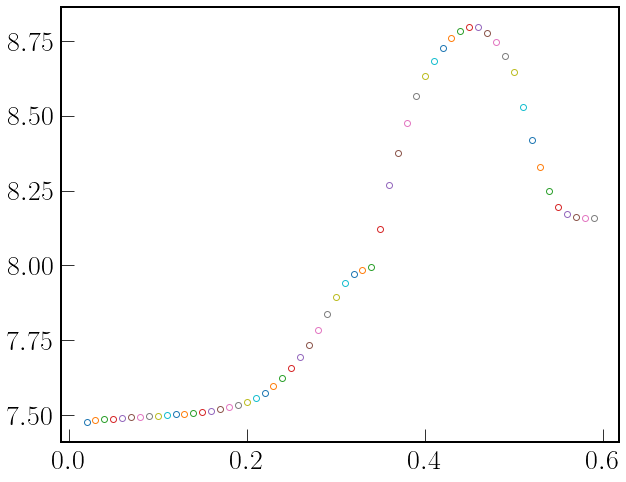

In [37]:
# fit the binding energy of different Ye
yes = np.arange(0.02,0.60,0.01)
Ebs = np.copy(yes)
yehs = np.copy(yes)
for (iye,ye) in enumerate(yes):#[0.]:#10.0**np.arange(7.0,14.0,1.0):
    d = 1.0e9
    t = 0.2
    prs = np.zeros((lt,2))
    enr = np.zeros((lt,2))
    
    # get things from NucEOS
    var.xrho = d
    var.xtemp = t
    var.xye = ye
    var = neos.nuc_eos_full(var,mode=ne.EOSMODE_RHOT)
    
    yeh = var.xzbar/var.xabar
    enr0 = var.xenr + \
                    (7.074-0.5*6.778-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxa +\
                    (0.0-6.778)*1.602e-6/1.6605e-24*var.xxp+\
                    (0.0-8.071323)*1.602e-6/1.6605e-24*var.xxn #+\
#   
    abar = 1./(var.xxn + var.xxp + 0.25*var.xxa + var.xxh/var.xabar)
    zbar = var.xye*abar
    h = helm.helmeos(dens=d,temp=t/kB,abar=abar,zbar=zbar)
    enr1 = h.etot

    EB = (enr1-enr0)/(1.602e-6/1.6605e-24*var.xxh)+ yeh*6.778 + (1.0-yeh)*8.071323
    plt.plot(ye,EB,'o',markerfacecolor='none')
    Ebs[iye]=EB
    yehs[iye]=yeh

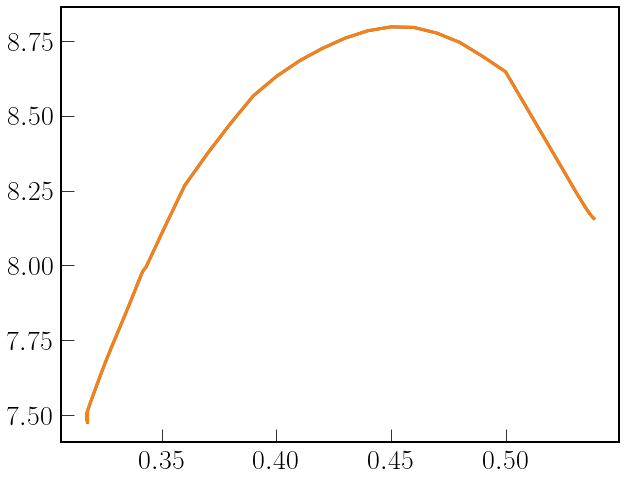

In [45]:
plt.plot(yehs,Ebs)
s1 = np.argsort(yehs)
plt.plot(yehs[s1],Ebs[s1])

In [46]:
# do interpolation on Eb vs. Ye
from scipy.interpolate import CubicSpline
s1 = np.argsort(yehs)
fEb = CubicSpline(yehs[s1],Ebs[s1])

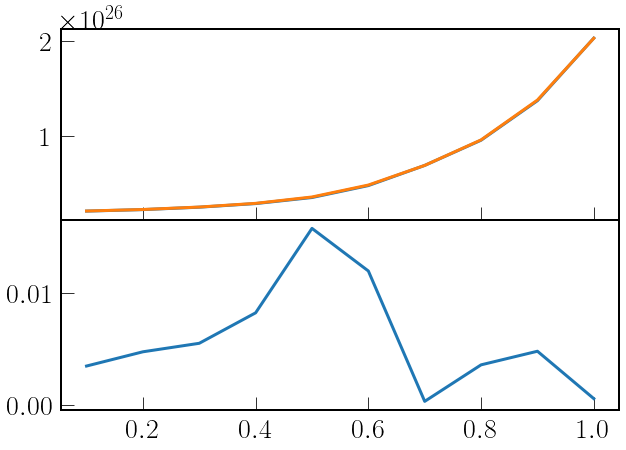

In [44]:
fig, axs = plt.subplots(2,1,figsize=(10,7),sharex=True)
fig.subplots_adjust(hspace=0.0)
axs[0].plot(np.arange(0.1,1.01,0.1),prs[:,0])
axs[0].plot(np.arange(0.1,1.01,0.1),prs[:,1])

axs[1].plot(np.arange(0.1,1.01,0.1),abs(prs[:,0]-prs[:,1])/prs[:,1])

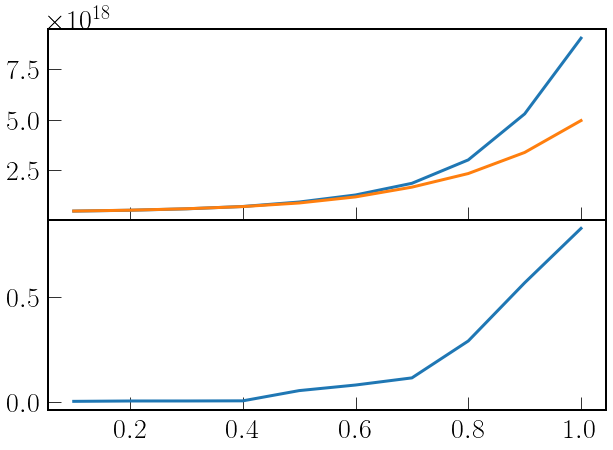

In [43]:
fig, axs = plt.subplots(2,1,figsize=(10,7),sharex=True)
fig.subplots_adjust(hspace=0.0)
axs[0].plot(np.arange(0.1,1.01,0.1),enr[:,0])
axs[0].plot(np.arange(0.1,1.01,0.1),enr[:,1])

axs[1].plot(np.arange(0.1,1.01,0.1),abs(enr[:,0]-enr[:,1])/enr[:,1])

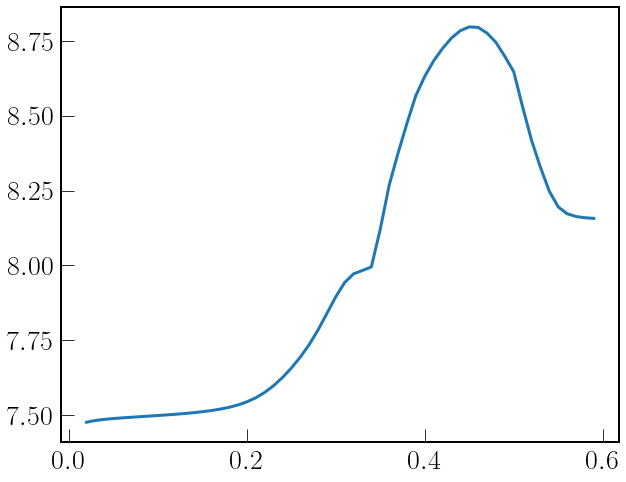

In [29]:
plt.plot(yes,Ebs)

In [38]:
var.xenr + (8.643-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24

4.745174266758363e+17

In [3]:
# check the inversion of hybEoS
d=1e9
t=0.5
ye=0.5

var.xrho = d
var.xtemp = t
var.xye = ye

var = neos.nuc_eos_full(var,mode=ne.EOSMODE_RHOT)
prs0 = var.xprs
enr0 = var.xenr

# get things from HelmEoS
abar = 1./(var.xxn + var.xxp + 0.25*var.xxa + var.xxh/var.xabar)
zbar = var.xye*abar
h = helm.helmeos(dens=d,temp=t/kB,abar=abar,zbar=zbar)
prs1 = h.ptot
enr1 = h.etot - ( (8.643-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxh + \
                    (7.073915-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxa+\
                    (6.777969-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxp+\
                    (8.071323-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxn)

#suppose a half combination
enr=0.5*(enr0+enr1)

In [23]:
# Get back T 
var.xenr=enr
var=neos.nuc_eos_full(var,mode=ne.EOSMODE_RHOE)
t0 = var.xtemp

abar = 1./(var.xxn + var.xxp + 0.25*var.xxa + var.xxh/var.xabar)
zbar = var.xye*abar
enr_h = enr+( (8.643-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxh + \
                    (7.073915-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxa+\
                    (6.777969-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxp+\
                    (8.071323-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxn)

invh = helmDE(d=d,e=enr_h,a=abar,z=zbar,tguess=t0/kB)
t1=invh.temp

[5.85536482e+09]
[5.85491796e+09]


In [30]:
def get_error(d,t,ye):
    # get the error in inversing Temperature and energy
    var = ne.EOSVariable()
    var.xrho = d
    var.xtemp = t
    var.xye = ye
    var = neos.nuc_eos_full(var,mode=ne.EOSMODE_RHOT)
    prs0 = var.xprs
    enr0 = var.xenr

    # get things from HelmEoS
    abar = 1./(var.xxn + var.xxp + 0.25*var.xxa + var.xxh/var.xabar)
    zbar = var.xye*abar
    h = helm.helmeos(dens=d,temp=t/kB,abar=abar,zbar=zbar)
    prs1 = h.ptot
    enr1 = h.etot - ( (8.643-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxh + \
                        (7.073915-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxa+\
                        (6.777969-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxp+\
                        (8.071323-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxn)

    #suppose a half combination
    enr=0.5*(enr0+enr1)
    prs=0.5*(prs0+prs1)
    
    # Get back T 
    var.xenr=enr
    var=neos.nuc_eos_full(var,mode=ne.EOSMODE_RHOE)
    t0 = var.xtemp
    prs0 = var.xprs

    abar = 1./(var.xxn + var.xxp + 0.25*var.xxa + var.xxh/var.xabar)
    zbar = var.xye*abar
    enr_h = enr+( (8.643-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxh + \
                        (7.073915-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxa+\
                        (6.777969-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxp+\
                        (8.071323-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxn)

    invh = helmDE(d=d,e=enr_h,a=abar,z=zbar,tguess=t0/kB)
    t1=invh.temp
    prs1=invh.ptot
    t_inv = 0.5*(t0+t1*kB)
    prs_inv= 0.5*(prs0+prs1)
    
    return t_inv, prs, prs_inv    

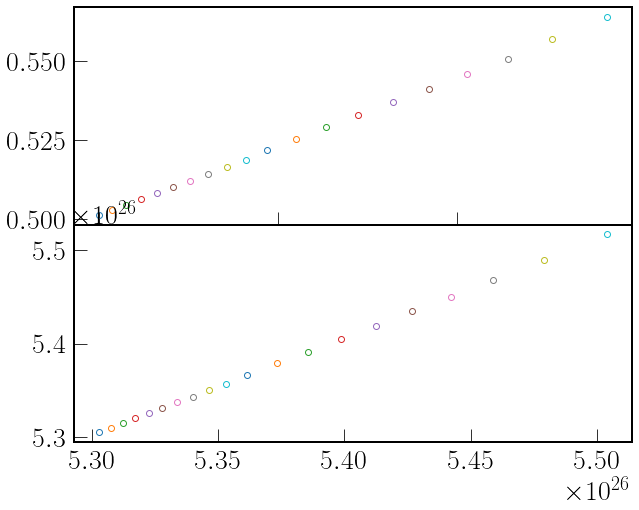

In [32]:
told = 0.5
fig, axs=plt.subplots(2,1)
fig.subplots_adjust(hspace=0)
for it in range(20):
    tnew,prs0,prs1 = get_error(1.0e9,told,0.5)
    axs[0].plot(told,tnew,'o',markerfacecolor='none')
    axs[1].plot(prs0,prs1,'o',markerfacecolor='none')
    told = tnew
    

In [20]:
def get_error(d,t,ye,W):
    # get the error in inversing Temperature and energy
    var = ne.EOSVariable()
    var.xrho = d
    var.xtemp = t
    var.xye = ye
    var = neos.nuc_eos_full(var,mode=ne.EOSMODE_RHOT)
    prs0 = var.xprs
    enr0 = var.xenr

    # get things from HelmEoS
    abar = 1./(var.xxn + var.xxp + 0.25*var.xxa + var.xxh/var.xabar)
    zbar = var.xye*abar
    h = helm.helmeos(dens=d,temp=t/kB,abar=abar,zbar=zbar)
    prs1 = h.ptot
    enr1 = h.etot - ( (8.643-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxh + \
                        (7.073915-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxa+\
                        (6.777969-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxp+\
                        (8.071323-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxn)

    #suppose a half combination
    enr=W*enr0+(1-W)*enr1
    prs=W*prs0+(1-W)*prs1
    
    # Get back T 
    var.xenr=enr
    var=neos.nuc_eos_full(var,mode=ne.EOSMODE_RHOE)
    t0 = var.xtemp
    prs0 = var.xprs

    abar = 1./(var.xxn + var.xxp + 0.25*var.xxa + var.xxh/var.xabar)
    zbar = var.xye*abar
    enr_h = enr+( (8.643-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxh + \
                        (7.073915-0.5*6.777969-0.5*8.071323)*1.602e-6/1.6605e-24*var.xxa+\
                        (6.777969-6.777969)*1.602e-6/1.6605e-24*var.xxp+\
                        (8.071323-8.071323)*1.602e-6/1.6605e-24*var.xxn)

    invh = helmDE(d=d,e=enr_h,a=abar,z=zbar,tguess=t0/kB)
    t1=invh.temp
    prs1=invh.ptot
    t_inv = W*t0+(1-W)*t1*kB
    prs_inv= W*prs0+(1-W)*prs1
    
    return t_inv, prs, prs_inv   

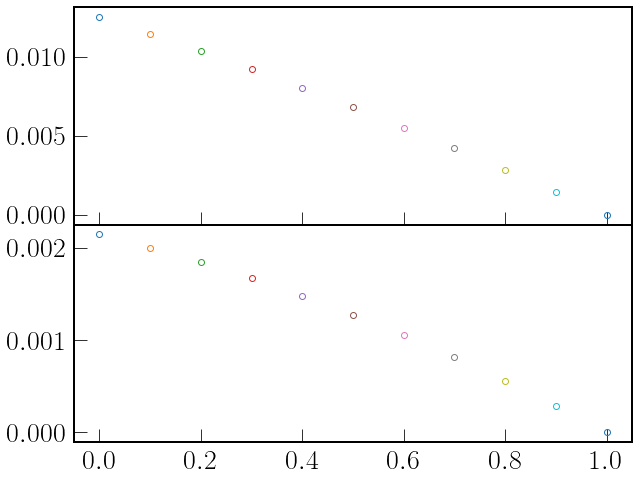

In [21]:
told = 0.5
fig, axs=plt.subplots(2,1)
fig.subplots_adjust(hspace=0)

for W in np.arange(0.0,1.01,0.1):    
    tnew, prs0,prs1 = get_error(1.0e9,told,0.5,W)
    
    axs[0].plot(W,(tnew-told)/told,'o',markerfacecolor='none')
    axs[1].plot(W,(prs1-prs0)/prs0,'o',markerfacecolor='none')

In [5]:
def helmDE(d=1.0e8,e=1e17,a=16,z=8,tguess=1.5e9):
    # my own Newton-Raphson solver for finding temperature
    tol = 1e-5
    ewant = e
    h = helm.helmeos(dens=d, temp=tguess, abar=a, zbar=z)
    eint = h.etot
    err = abs((eint-ewant)/eint)

    iter = 0
    while err > tol:

        tnew = tguess + (ewant-eint)/h.det
        if tnew > 10*tguess:
            tnew = 10*tguess
        elif tnew < 0.1*tguess:
            tnew = 0.1*tguess
        #print(tnew)
        h = helm.helmeos(dens=d, temp=tnew, abar=a, zbar=z)
        eint = h.etot
        err = abs((eint-ewant)/eint)
        tguess = tnew
        iter = iter+1

        if iter >=20:
            break
    return h

In [23]:
26/56

0.4642857142857143